In [1]:
from typing import Optional

import pytorch_lightning.loggers as pl_loggers
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision import transforms

from slot_cut.data import CLEVRTEXDataModule

from slot_cut.method import SlotCutMethod
from slot_cut.model import SlotCutModel
from slot_cut.params import SlotCutParams
from slot_cut.utils import ImageLogCallback
from slot_cut.utils import rescale
import os
import subprocess
import torch
import sys

import mediapy as media

/var/scratch/aapervez/anaconda3/envs/slot-c11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
params = SlotCutParams()
params.chk_path = 'log/checkpoint.ckpt'
#One of 'full', 'camo', or 'outd'
clevrtex_variant ='full'

In [10]:
img_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(rescale),  # rescale between -1 and 1
        transforms.Resize(params.resolution),
    ]
)

datamodule = CLEVRTEXDataModule(
    data_root=params.data_root,
    clevrtex_variant=clevrtex_variant,
    max_n_objects=params.num_slots - 1,
    resolution=params.resolution,
    train_batch_size=params.batch_size,
    val_batch_size=params.val_batch_size,
    clevr_transforms=img_transforms,
    num_train_images=params.num_train_images,
    num_val_images=params.num_val_images,
    num_workers=params.num_workers,
)

reading from  /local-ssd/aapervez
Indexing /local-ssd/aapervez/clevrtex_full
Sourced full (train) from /local-ssd/aapervez/clevrtex_full
reading from  /local-ssd/aapervez
Indexing /local-ssd/aapervez/clevrtex_full
Sourced full (val) from /local-ssd/aapervez/clevrtex_full
reading from  /local-ssd/aapervez
Indexing /local-ssd/aapervez/clevrtex_full
Sourced full (test) from /local-ssd/aapervez/clevrtex_full


In [11]:
model=SlotCutModel(
        resolution=params.resolution,
    num_slots=params.num_slots,
    empty_cache=params.empty_cache,
)

method = SlotCutMethod.load_from_checkpoint(params.chk_path, strict=False, model=model, datamodule=datamodule, params=params)

Begin Cholesky


/var/scratch/aapervez/work/slot_attention/cut/st.py:206: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  F = cholesky_AAt(A, ordering_method='nesdis')


End Cholesky  1.2511320114135742
Density  0.060653209365500935
Size  270.013164


In [12]:
trainer = Trainer(
    logger=False, 
    accelerator="ddp" if params.gpus > 1 else None,
    num_sanity_val_steps=params.num_sanity_val_steps,
    gpus=params.gpus,
    max_epochs=params.max_epochs,
    log_every_n_steps=50,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
_=trainer.predict(method)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0:   1%|██▏                                                                                                                                                                              | 1/79 [00:01<01:53,  1.46s/it]

/var/scratch/aapervez/anaconda3/envs/slot-c11/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:137: UserWarning: predict returned None if it was on purpose, ignore this warning...
  self._warning_cache.warn("predict returned None if it was on purpose, ignore this warning...")


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:12<00:00,  1.67s/it]
Metrics  {'mse': 207.4264693359375, 'miou': 0.42424838147595484, 'ari': 0.5153499259960134, 'ari-fg': 0.8025060223715996}
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:12<00:00,  1.67s/it]


In [18]:
images = method.sample_images().permute(1,2,0)

""

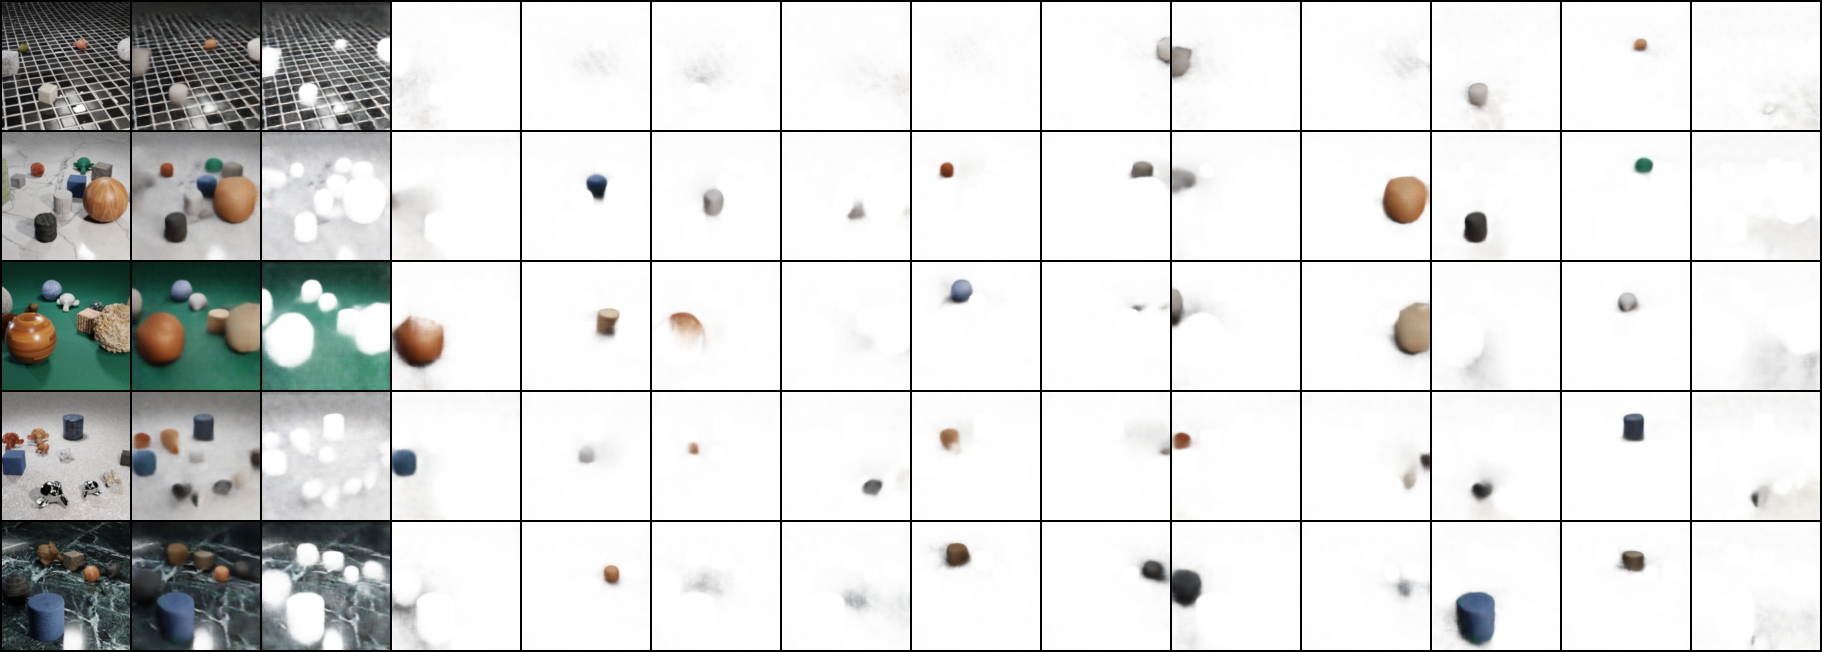

In [19]:
media.show_image(images)